In [1]:
# sys, file and nav packages:
import datetime as dt
import warnings

# math packages:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import poisson
from scipy.stats import norm
import pymc3 as pm
import empiricaldist
from empiricaldist import Pmf
import arviz as az

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.gridspec import GridSpec

# images and display
# import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display

# set some parameters:
# today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2015-11-01'
end_date ='2021-11-01'

dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map location slug to the proper city name
city_map = dfBeaches['city']

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# all data since 2015
x = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")

# xl = x[x.water_name_slug == "lac-leman"].copy()

ldb = x[x.water_name_slug == "lac-leman"].copy()

# assign loc_date
ldb['loc_date'] = list(zip(ldb.location, ldb['date']))

# date to datetime
ldb['date'] = pd.to_datetime(ldb['date'], format="%Y-%m-%d")
ldb = ldb[ldb["date"]<="2021-11-01"]
ldb["year"] = ldb["date"].dt.year

# agg levels
samp_loc = ['loc_date', 'location']
ldate = ['loc_date']
city = ['Genève']

# agg columns
qandp = {'quantity':'sum', 'pcs_m':'sum'}
qandnsamps = {'quantity': 'sum', 'loc_date':'nunique'}

# agg codes and groups
code = ['G144', 'G96']
# groupname = ['waste water']

sg = ldb.city.isin(city)
# fhw = (ldb.groupname.isin(groupname))
fhg = ldb.code.isin(code)
gzero = ldb.quantity > 0

# define the sampling periods

# year one
y_o_s = "2015-11-15"
y_o_e = "2017-03-31"

# year two
y_t_s = "2017-04-01"
y_t_e = "2018-05-01"

# year three
y_th_s = "2021-11-01"

# map the periods to the data
y_one = ldb['date'] <= y_o_e
y_two = (ldb['date'] >= y_t_s) & (ldb['date'] <= y_t_e)
y_thre = (ldb['date'] > y_t_e) &(ldb['date'] <= y_th_s)

# make a seperate df for each
year_one = ldb[y_one].copy()
year_two = ldb[y_two].copy()
year_three = ldb[y_thre].copy()

# store the dfs in an array
dfs =  [year_one, year_two, year_three]

# summarize all instances at all locations
# the total objects per location, number of samples, number of target objects, number of samples with target objects
# adlt = ldb.groupby(['city','location']).agg(qandnsamps)

# adlt.rename(columns={'loc_date':'n samples', 'quantity':'qd'}, inplace=True)
# foundfhg =ldb[fhg&gzero].groupby(['city','location']).agg(qandnsamps)

# fhg_summary = pd.concat([adlt,foundfhg], axis=1)
# fhg_summary.fillna(0, inplace=True)
# fhg_summary.rename(columns={'quantity':'q_fhg', 'loc_date':'s_pos'}, inplace=True)
# fhg_summary.reset_index(inplace=True)

In [2]:
def make_a_summary_table(ax, data,colLabels, a_color="black", font_size=12, s_et_bottom_row=True, coded_labels=False, codes=[]):
    
    """Formats matplotlib table object.

    Args:
    ax: object: matplotlib table object
    data: array: the 2d array used to generate the table object
    cols_to_use: array: the list of column names
    a_color: str: matplotlib named color, face and edgecolor of table cells
    font_size: int: the font size for the table cells
    s_et_bottom_row: bool: whether or not to draw bottom line on the last row

    Returns:
    The table object formatted.
    """

    ax.auto_set_font_size(False)
    the_cells = ax.get_celld()

    line_color = mcolors.to_rgba("black")
    banded_color = (*line_color[:-1], 0.1)

    # the different areas of formatting
    top_row = [(0, i) for i in np.arange(len(colLabels))]
    bottom_row = [(len(data), i) for i in np.arange(len(colLabels))]
    data_rows = [x for x in list(the_cells.keys()) if x not in top_row]
    
    if coded_labels:
        for i, a_cell in enumerate(top_row):
            ax[a_cell].get_text().set_text("")
            
            cell_color = mcolors.to_rgba(codes[i])
            c_color = (*cell_color[:-1], 0.6)
            ax[a_cell].set_facecolor(c_color)
            ax[a_cell].set_linewidth = 1
            ax[a_cell].set_height( .4/ (len(data)))
        
        
        
    else:
        for i, a_cell in enumerate(top_row):
            ax[a_cell].visible_edges = "B"
            ax[a_cell].set_text_props(**{"fontsize": font_size})
            ax[a_cell].set_edgecolor("black")
            
            ax[a_cell].PAD = .2
            ax[a_cell].set_linewidth = 1
            ax[a_cell].set_height(.5 / (len(data)))

    for a_cell in data_rows:
        ax[a_cell].set_height(.5 / (len(data)))
        ax[a_cell].visible_edges = "BT"
        ax[a_cell].set_text_props(**{"fontsize": font_size})
        ax[a_cell].set_edgecolor(banded_color)
        ax[a_cell]._text.set_horizontalalignment("center")
        ax[a_cell].set_linewidth = .1

    if s_et_bottom_row is True:
        
        for a_cell in bottom_row:
            ax[a_cell].visible_edges = "B"
            ax[a_cell].set_edgecolor(line_color)
            ax[a_cell].set_linewidth = 1

    return ax



def a_simple_formatted_table(ax,data,colLabels=[], a_color="black", colWidths=[], bbox=[], coded_labels=False, codes=[],**kwargs):
    """Makes a table with rows from a matplotlib axes object and a 2d array. Header row is
    spererated from table body by a thicker black line. 
    
    :param ax: An axes
    :type ax: matplotlib axes
    :param data: An array of the table values not including column names or labels
    :type data: array
    :param colLabels: The labels for the data table columns
    :type colLabels: array
    :param a_color: The color of the cell borders
    :type a_color: str
    :param colWidths: The width of each column in fractions of 1
    :type colWdiths: array, x < 1
    :param bbox: The location of the table in figure space
    :type bbox: array
    :return: A table on the provided axis
    :rtype: matplotlib.axes
    
    """
    a = ax.table(data,  colLabels=colLabels, colWidths=colWidths, bbox=bbox, loc="lower center", **kwargs)
    t = make_a_summary_table(a, data, colLabels, a_color=a_color, font_size=12, s_et_bottom_row=False, coded_labels=coded_labels, codes=codes)
    return t
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return ax
def remove_ticks(ax):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    return ax   

## INTRODUCTION 

According to a Brief History of Marine Litter, the first scientifically recorded interaction between marine organisms and persistent litter was in 1969 {cite}`briefhistory`. In 1972 the International Journal of Environmental Studies observed that most of the trash on isolated stretches of ocean shoreline was a result of sea‐borne waste. The waste is primarily a by‐product of international commerce and not the behavior of the casual visitor {cite}`scottdebunksource`.  This document picks up the trail 50 years later and several hundred miles upstream.  While the harmful effects of plastic are (apparently) debatable, its occurrence on our beaches and in our water is undeniable.  Volunteers, applying common sense protocols put in place over the past twenty years, have created a very accurate picture of the occurrence of plastics at sea and on inland lakes and rivers.  

The United Nations published a first international guide to collecting ocean beach litter in 2008 {cite}`unepseas`. This publication was followed by another guide developed by OSPAR {cite}`osparguidelines` in 2010 and then, in 2013, the EU published the Guidance on Monitoring Marine Litter in European Seas {cite}`mlwguidance`. Riverine Litter Monitoring - Options and Recommendations was published later, in 2016, as evidence was mounting that rivers are major sources of marine litter.  {cite}`riverinemonitor` As a result, thousands of observations have been collected following a very similar protocol {cite}`mlwdata` {cite}`ospardata`. These data are collected by different organizations, mostly volunteer, throughout the European continent. Each observation is a categorical list of objects and their respective quantities within a defined length of shoreline, the EU standard is 100 meters. However, when the baseline values were defined, all samples within a beach length greater than 10 meters were considered {cite}`mlwguidance` {cite}`osparguidelines`. The same protocol has been in place in Switzerland since November 2015, targeting regional lakes and rivers. {cite}`iqaasl` 

The data collected by volunteers were considered fit for the purpose of establishing beach-litter threshold values by the Marine Litter Technical Group of the EU. However, the lack of quantitative research on the harmful effects of beach litter, specifically the dose-effect relationship between plastic and ecological harm, precludes the establishment of threshold values based on this metric. Therefore, threshold values and baselines needed to be adopted according to the precautionary principle to limit exposure. Threshold values could not be based on the socio-economic effects of beach litter either because the negative effects have proven difficult to define quantitatively.  {cite}`threshholdeu`. In practice, EU threshold values are determined by using the 15th percentile (20 p/100m) from the combined data set of 2015-2016 beach litter surveys within the EU. {cite}`threshholdeu`  Thus, this threshold can be interpreted as a ratio of the given the survey data greater than 20 p/100m or 85%. 

 Considering that the median value was 133 p/100 m in the 2015-2016 beach litter surveys, it means that regional administrations will need to allocate resources to meet the threshold value if they want to achieve good environmental status under the Marine Strategy Framework Directive {cite}`goodenvironmentalstanding`. At the same time, determining which are the most effective solutions will require that stakeholders conduct intermediate assessments based on benchmarks to evaluate progress and compare probable outcomes. This requires having adequate statistical tools. 

Additionally, the potential applications for beach litter data go beyond establishing threshold values. Developing Life Cycle Assessments is an excellent example. The Life Cycle Initiative (LCI) is a public-private partnership that includes France, Switzerland, Germany and the EU with a stated goal of advancing the understanding of life cycle thinking by private and public decision makers. In partnership with Plastics Europe, LCI has been attempting "to integrate potential environmental impacts of marine litter, especially plastic, in Life Cycle Assessment (LCA) results".  {cite}`marilca` {cite}`lci`.The consequences of plastic leaked into the environment are not accounted for in the current practice of LCA {cite}`woods2021107918`. This could be in part for the same reasons that the EU adopted the precautionary principle, as opposed to dose-effect relationships when developing threshold values.   

Nevertheless, recent attempts have been made to develop a Marine Litter Indicator (MLI) for LCAs. For instance, based on the commonsense hypothesis that there is a relationship between the number of objects produced, value of those objects once the product is consumed, and the likelihood that they will be littered, it was concluded that returnable PET bottles or returnable glass bottles would have the lowest MLI, all things considered {cite}`plasticorglass`. A very similar method was used when proposing an MLI for plastic carrier bags. {cite}` civancikuslu2019621` 

If the reason for adopting a threshold value is based on the precautionary principle, then, ultimately, the threshold value is an attempt to limit exposure. For the LCA it appears that the lifecycle of the product ends when the original product is no longer identifiable {cite}`plasticorglass`, ie.. exposure ends when the object/product is no longer recognizable. Beach litter surveys account for both cases (i) Identifiable objects and (ii) fragmented plastics of different sizes.  Beach litter survey results are not included in the calculation of the proposed MLI. {cite}`plasticorglass` {cite}`civancikuslu2019621` 

In both cases, EU thresholds and LCAs, are attempts at reducing the probability of the event “an object was found on the beach today” but none answers the general question “How likely is an object to be found”.   This can be done by recalling that probability is a ratio not a frequency and applying Bayes theorem to the survey results for objects or groups of objects {cite}`Jaynes`. The development and application of the method is illustrated through its application to a particular case: object, feminine hygiene products (FHP) and system, beaches in Geneva, Switzerland. Both are briefly introduced below. 

Clean up events and awareness campaigns have played a major role in identifying the principal components of beach litter and the presence of plastics in the environment. One such campaign is End Period Plastics in the UK who is working to eliminate plastics in feminine hygiene products (FHP). The campaign includes meetings throughout Europe with manufacturers, suppliers and vendors of plastic FHP. In preparation for a meeting with a producer of FHP in Geneva, the team from End Period Plastics was interested in knowing the incidence of these objects in Lake Geneva {cite}`endperiodplastics`. Their request is at the origin of this study. Tampon applicators and tampons are part of a group of specific items that are found on beaches and that most likely originate from toilet flushing or a wastewater treatment facility, cotton-swabs are also part of that group.  {cite}`obriain2020116021` {cite}`padbackingstrips` {cite}`increasingplastics`  

Beach litter monitoring on Lake Geneva started in November 2015 using the MSFD method. Data has been collected at irregular intervals since then. Geneva beaches (xxx) have been sampled intermittently since the start, in contrast to other beaches such as those in other parts of the lake such as in Saint Sulpice (xxx) which has fewer samples but has samples between October and November every year. The Rhône outflow into the Mediterranean Sea is also monitored using the same protocol as Lake Geneva thus using the values from different locations in the same river basin to assess probable values at any location in that river basin depending on the data.  Bayes theorem is used as a method to determine the location in Geneva beaches where the probability of finding an FHP is highest by comparing the probability of finding an FHP and covariates at different temporal and geographical bounds. A litter survey was conducted with End Period Plastics staff and hammerdirt surveyors to illustrate the abundance of FHP on the lake. Because of time and transportation constraints, this litter survey had to be conducted on a site with the following criteria: (i) access with public transport, (ii) completed in less than three hours, and (iii) preferably a location where there was a chance to find this specific item quickly. 

## DATA AND METHODS 

### Study sites 

Lake Geneva is a perialpine lake at an altitude of 372 m above mean sea level located between France and Switzerland. It has an elongated shape, a surface area of 580 km2, and maximum length and width of 72.3 and 14 km, respectively. The average water residence time is 11.3 years. The lake is subdivided into two sub-basins: the Grand Lac (large lake) (309 m deep) and the Petit Lac (small lake) (medium-sized basin with a volume of 3 km3 and a maximum depth of about 70 m.  Lake Geneva is fed by a large number of rivers and streams but most of the water enters through the Rhône River. The permanent population (2011) in its watershed is: 1,083,431 (France: 142,229, Switzerland: 941,202) but also hosts a large tourism population. There are 171 wastewater treatment plants (population equivalent: 3,009,830). {cite}`cipel2019` 

Geneva beaches (baby plage, baby plage II, Jardin botanique, rocky plage, villa barton), are located in the Petit Lac (Figure 1). St Sulpice beaches (parc des pierrettes, plage de dorigny, plage de st-sulpice, saint-sulpice, tiger-duck beach), whose data is also used in this study, in the Grand Lac (Figure 1).

#### Map here

Lake Geneva is connected to the Mediterranean Sea by the Rhône River. The city of Port Saint Louis is at the mouth of the Rhône where it discharges into the sea. Port Saint Louis benefits from regular monitoring using the same protocol and coding system as Switzerland {cite}`merter`.  

### Data



The first sample was recorded on Lake Geneva on November 23, 2015. Between November 2015 and June 2021 there were 247 beach-litter surveys at 38 different locations. In total, 78,104 objects were removed and identified, of which 358 objects were either tampons or tampon applicators (0.45%). {cite}`iqaasl` 

There are three separate sampling periods, each sampling period represents an initiative or campaign. The sampling periods are not of the same length nor is the sampling frequency fixed, except for a few specific locations in periods two and three. There were no samples collected in Geneva beaches during sampling period two. 

1. Project one: 2015-11-15 to 2017-03-01; the first project on Lac Léman (MCBP) 

2. Project two: 2017-04-01 to 2018-05-01; the Swiss Litter Report (SLR) 

3. Project three: 2020-03-01 to 2021-11-01; the start of IQAASL up to two weeks before the survey with End Period Plastics. 

FHP were present in 102 samples (41%). However, FHP are not found at the same rate at all locations. There were ten locations with only one sample (all periods included), of those ten at least one FHP was identified in four of the ten samples/locations. 

Of the other 28 locations, FHP were found at all locations except for three. Those three locations, in different regions of the lake, had two samples each. All locations with at least three surveys had at least one FHP identified in a survey, the minimum ratio of samples with FHP was 0.07 at baye-de-clarens. There were two locations that had a ratio of 1 (all samples have FHP products), la-pecherie in Allaman and parc-des-pierrettes in Saint Sulpice, see Annex table 1a. 

Table 1.  Number of locations, samples and positive samples per sampling period in Lake Geneva. Table 2. Number of locations, samples and positive samples per period for all locations within the city limits of Geneva city. 

The shores of Saint Sulpice (Grand Lac) have been monitored yearly since 2016 by students of the EPFL.  

The median beach litter survey value on Mediterranean Beaches was 294 p/100m {cite}`threshholdeu`. 

Statistical methods 

The location with the greatest probability, theta, of finding an FHP on a given sampling day will be determined by considering, for each location of interest, the data up to the day prior to sampling. The statistical conclusions about the parameter theta are made in terms of probability statements. {cite}`bayesgelman` 

Before any statement can be made about the relationship between the data and theta, they must be combined into a joint probability distribution. Bayes' rule does that by setting the conditional probability of theta to the observed data, p (θ|data) as: 

#### Formula one

Note that the expression to the left of the equal sign reads "the probability of theta given the data", which is different from p( data | theta ). In p (θ|data),  theta is being conditioned by the observations, in p( data | theta ), the data is being conditioned by theta. {cite}`bayesdowney` 

These statements conform to a common-sense interpretation about any conclusions that may arise from the observed survey results.  To understand what is meant by common sense interpretation consider the series of questions that might be asked in order to gather the necessary information required to decide which location might have the greatest value of theta, prior to examining the data: 

* What is the value of theta for the lake? 

* Is it the same at all locations? 

* What is the value of theta Geneva? 

* Is it greater or less than the lake? 

* Is it the same at all locations in Geneva? 

* Where is the best chance of finding an FHP in Geneva if all the data for the lake is available? 

* Where is the best chance of finding an FHP in Geneva if only a subset of the data is available? 

* Do objects with similar sources have similar results? 

* Do other cities have similar results? 

* Were the samples gathered in the same way? 

* What is the difference between condition three and four? 

* Is four within the range of three? 

* Does the conclusion change given condition three or four? 

* Where am likely to find the most in the river basin?  How does Geneva compare? 

* Given the data, how reasonable are the answers to these questions? 

The uncertainty of those conclusions is defined by the range of the 94% Highest Density Interval of probability (HDI) as opposed to a confidence interval. The interval of probability contains the likely values of theta given the data and our prior beliefs. {cite}`bayesgelman` {cite}`bayesdowney` {cite}`bayespillon` 

The probability distribution of θ given the data, or posterior, can be defined in more general terms as: 

#### formula 2

where the prior is the estimate or belief about theta prior to seeing the data and the likelihood is the chance of observing the data given theta, the normalizing constant is the total probability of the data and ensures that, when theta is integrated on [0,1], it integrates to 1. {cite}`bayesrules` 

To construct the model, the prior, posterior and likelihood functions need to be defined. The probability of finding an FHP anywhere on the lake ranges from [0,1] and is not constant. Thus, theta can take on different values depending on the quantity at the location of interest and the surveyor's ability to find and recognize the object as an FHP. 

The results for each survey are transformed to Boolean values. If an FHP was recorded at a survey, FHP = 1 and is 0 otherwise. This reduces each survey to one independent Bernoulli trial. Therefore, the probability of finding an FHP at any location in n samples can be described by the probability mass function of the Binomial distribution {cite}`bindistwiki`: 

#### formula 3

In this configuration (3) theta only takes on one value. To account for the different possible values of theta, its' value can be set to the Beta distribution resulting in a Binomial distribution with parameter theta which is defined by a Beta distribution with parameters alpha and beta.

#### formula 4

#### formula 5

The Beta distribution, defined on [0,1], takes two parameters, the number of times that an FHP was found = alpha, and the number of times that an FHP was not found = beta (n-FHP). A conjugate prior to the Binomial distribution, this model has many applications to any situation where the parameter of interest is in the range [0,1]. {cite}`bayesgelman` {cite}bayesjefferys {cite}`bayesrules` 

The probability density function of the Beta distribution is {cite}`betawiki`: 

#### formula 6

When sampling started in 2015, there were no reference values for the region. Count surveys of litter data in the maritime environment had produced volumes of data but under significantly different conditions. Without reference values, we had no prior assumptions on the probability of finding an FHP and assumed that the probability was the same for all locations on the lake. The assumed distribution of theta prior to November 2015 is therefore a standard uniform distribution defined by Beta(1,1).  This reflects the experience and expectations at the time. {cite}`bayesjefferys` {cite}`catalogofpriors` {cite}`noninformativepriors` 

The general forms in equations 1 and 2 can now be defined using elements of 3 and 6, according to the model defined in 4 and 5. Note that the second and third expressions on the right side of the equations in 3 and 6 are the same for the Binomial and Beta distributions.

#### formula 7

#### formula 8 

#### formula 9

Putting that together by dropping the normalizing constants that do not depend on theta (10) and combining like values results in the posterior distribution of theta (11).

#### formula 10

#### formula 11

The posterior distribution of theta (11) is an unnormalized Beta distribution with parameters alpha and beta.  This means that the prior uninformed estimate in November 2015 can be updated with the data from each sampling period in sequence. {cite}`bayesrules`  {cite}`bayesdowney` 

Using this method, the results from sampling period one (which incorporate the initial estimate) become the prior distribution for the results of sampling period two and this process is repeated until the last sampling period. {cite}`bayesdowney`

__Assumptions__

* The samples are independent and identically distributed
* Theta is approximately equal for all locations which is the expected value for the lake
* The expected result for the lake or the region is the best estimate for locations without samples
* Exchangeability of data {cite}`bayesgelman` 

__Computational methods__

Markov Chain Monte Carlo (MCMC) was used. MCMC is a general method used to simulate probability models. A Markov chain is a model that describes a sequence of possible events where the probability of each event depends only on the results of the previous event. {cite}`bayeskruschke`  {cite}`bayesdowney` {cite}`bayespilon` 

The implementation of MCMC methods is done with PyMC3 v3.1 {cite}`pymc` and the results are analyzed with ArviZ v0.11.4 {cite}`arviz`, SciPy v1.7 {cite}`scipy` and pandas v1.34 {cite}`reback2020pandas` all running in a Python v3.7 {cite}`python` environment. 

The data and methods are available in the repository: https://github.com/hammerdirt-analyst/finding-one-object 

## RESULTS AND DISCUSSION 

The probable mean values of theta lake (Figure 2, Table three) from one sampling period to the next is an example of how new data changes the expectation of finding an FHP on the beach as more samples are acquired. Consider that the difference between the 97% and 3% interval for each sampling period gets smaller as more data is added. Thus, decreasing uncertainty about the incidence of FHP on the lake and the probability of finding one, by year three it is 94% certain that the chance of finding an FHP on the beach is between 35% and 47% with an expected value of 41% (Table three).   

As shown in Figure 2, it is apparent that the probability of finding FHPs in the whole lake was not the same at every survey. The expected probability is highest in year two, but the smallest 94% HDI is observed in year three: 12%. Recall that there were no samples in period two in Geneva and that not all locations were sampled in each sampling period (Table 2). 

In [14]:
plac = [
    "Prangins",
    "Promenthoux",
    "Nyon",
    "Crans-près-Céligny",
    "Céligny", 
    "Founex",
    "Coppet",
    "Tannay",
    "Mies",
    "Versoix",
    "Genthod",
    "Bellevue",
    "Pregny-Chambésy",
    "Hermance",
    "Anières",
    "Corsier",
    "Collonge-Bellerive",
    "Vésenaz",
    "Cologny",
    "Genève",]
plac_beaches = dfBeaches[dfBeaches.city.isin(plac)].index.to_numpy()

glac = [
    "Bourg-en-Lavaux",
    "Puidoux", 
    "Cully", 
    "Grandvaux", 
    "Villette (Lavaux)", 
    "Lutry", 
    "Paudex", 
    "Pully", 
    "Lausanne", 
    "St-Sulpice (VD)", 
    "Préverenges", 
    "Morges", 
    "Tolochenaz", 
    "St-Prex", 
    "Buchillon", 
    "Allaman", 
    "Perroy", 
    "Rolle", 
    "Bursinel", 
    "Dully", 
    "Gland",
]
glac_beaches = dfBeaches[dfBeaches.city.isin(glac)].index.to_numpy()

hlac = [
    "Noville",
    "Villeneuve (VD)",
    "Veytaux",
    "Territet",
    "Montreux",
    "Clarens",
    "La Tour-de-Peilz",
    "Vevey",
    "Corseaux",
    "St-Saphorin (Lavaux)",
    "Rivaz",
    "Port-Valais",
    "Saint-Gingolph"    
]   

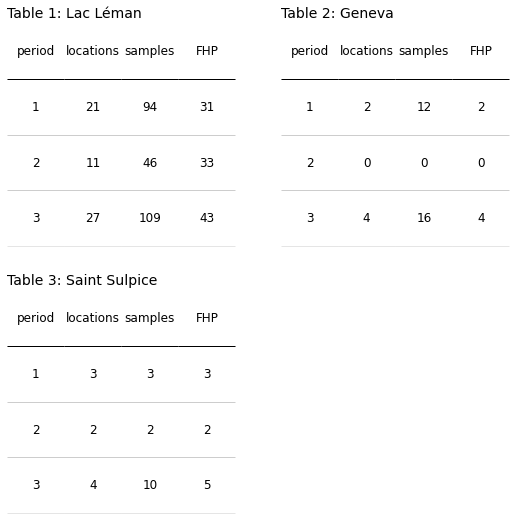

In [15]:

# fhg_summary["rate"] = fhg_summary.s_pos/fhg_summary["n samples"]

# assign a period to each sample
ldb['period'] = 1
ldb.loc[y_two, 'period'] = 2
ldb.loc[y_thre, 'period'] = 3

# identify the zero values
just_fhg = ldb[fhg].copy()
just_fhg['found'] = False
just_fhg.loc[(just_fhg.quantity > 0), 'found'] = True

# count the positive values y for each period and region
geneva = just_fhg[just_fhg.city.isin(city)]
sulpice = just_fhg[just_fhg.city.isin(['Saint-Sulpice (VD)'])]
p_lac = just_fhg[just_fhg.city.isin(plac)]

summary_sulpice = sulpice.groupby('period', as_index=False).agg({'location':'nunique', 'loc_date':'nunique', 'found':'sum'})
summary_sulpice.rename(columns={'loc_date':'samples','found':'FHP', 'location':'locations'}, inplace=True)
summary_sulpice.sort_values(by='period', inplace=True)
summary_sulpice.reset_index(drop=True, inplace=True)


summary_geneva = geneva.groupby('period', as_index=False).agg({'location':'nunique', 'loc_date':'nunique', 'found':'sum'})
summary_geneva.rename(columns={'loc_date':'samples','found':'FHP', 'location':'locations'}, inplace=True)

#there were  no samples in Geneva durring the second sampling period
summary_geneva.loc[2] = 2,0, 0, 0
summary_geneva.sort_values(by='period', inplace=True)
summary_geneva.reset_index(drop=True, inplace=True)

summary_just_fhg = just_fhg.groupby('period', as_index=False).agg({'location':'nunique', 'loc_date':'nunique', 'found':'sum'})
summary_just_fhg.rename(columns={'loc_date':'samples','found':'FHP', 'location':'locations'}, inplace=True)

fig, ax = plt.subplots(2,2, figsize=(9,9))

axone = ax[0,0]
axtwo= ax[0,1]
axthree=ax[1,0]

table_one = a_simple_formatted_table(axone,summary_just_fhg.values,colLabels=summary_just_fhg.columns, a_color="black", colWidths=[*[.25]*4], bbox=[0,0,1,1])
axone = remove_spines(axone)
axone = remove_ticks(axone)
# axone.set_xlabel("Lac Léman", fontsize=14, labelpad=14)
axone.set_title("Table 1: Lac Léman", fontsize=14, loc="left")

table_two = a_simple_formatted_table(axtwo,summary_geneva.values,colLabels=summary_geneva.columns, a_color="black", colWidths=[*[.25]*4], bbox=[0,0,1,1],)
axtwo = remove_spines(axtwo)
axtwo = remove_ticks(axtwo)
#axtwo.set_xlabel("Geneva", fontsize=14, labelpad=14)
axtwo.set_title("Table 2: Geneva", fontsize=14, loc="left")

table_three = a_simple_formatted_table(axthree,summary_sulpice.values,colLabels=summary_sulpice.columns, a_color="black", colWidths=[*[.25]*4], bbox=[0,0,1,1],)
axthree = remove_spines(axthree)
axthree = remove_ticks(axthree)
# axthree.set_xlabel("St Sulpice", fontsize=14, labelpad=14)
axthree.set_title("Table 3: Saint Sulpice", fontsize=14, loc="left")
ax[1,1].axis("off")


plt.show()

In [29]:
p_lac[p_lac.location == "villa-barton"].groupby('period', as_index=False).agg({'loc_date':'nunique', 'found':'sum'})

,period,loc_date,found
0,1,9,0
1,3,2,1


In [16]:
p_lac.groupby('period', as_index=False).agg({'location':'nunique', 'loc_date':'nunique', 'found':'sum'})

,period,location,loc_date,found
0,1,3,13,3
1,3,5,19,4


In [32]:
p_lac.location.unique()

array(['villa-barton', 'baby-plage-geneva', 'versoix', 'jardin-botanique',
       'baby-plage-ii-geneve', 'rocky-plage'], dtype=object)

In [33]:
p_lac[p_lac.location == 'baby-plage-geneva'].groupby('period', as_index=False).agg({'loc_date':'nunique', 'found':'sum'})

,period,loc_date,found
0,3,11,3


In [34]:
3/11


0.2727272727272727

In [21]:
# probability of an fhp on the lake is
from scipy.stats import beta
from scipy.stats import binom

In [22]:
g27 = ldb[ldb.code.isin(["G27"])].copy()
print(g27.fail.sum(), g27.loc_date.nunique())

229 249


In [28]:
a = beta(6, 22)
beta.stats(6, 22)

(array(0.21428571), array(0.00580577))

In [25]:
15/40

0.375

In [24]:
a.mean()

0.9196787148594378

In [9]:
Xlake = pd.concat(dfs[:-1])
Xlake

,Unnamed: 0,date,code,pcs_m,quantity,location,loc_date,water_name_slug,river_bassin,length,...,% to water,% to unproductive,streets,month,eom,material,w_t,streets km,p/100m,year
140,140,2016-07-22,G10,0.43,6,villa-barton,"(villa-barton, 2016-07-22)",lac-leman,rhone,14.019905,...,1.133333,0.0,85080,7,2016-07-31,Plastic,l,85.080,43.0,2016
141,141,2016-07-22,G34,0.29,4,villa-barton,"(villa-barton, 2016-07-22)",lac-leman,rhone,14.019905,...,1.133333,0.0,85080,7,2016-07-31,Plastic,l,85.080,29.0,2016
142,142,2016-07-22,G175,0.14,2,villa-barton,"(villa-barton, 2016-07-22)",lac-leman,rhone,14.019905,...,1.133333,0.0,85080,7,2016-07-31,Metal,l,85.080,14.0,2016
143,143,2016-07-22,G66,0.36,5,villa-barton,"(villa-barton, 2016-07-22)",lac-leman,rhone,14.019905,...,1.133333,0.0,85080,7,2016-07-31,Plastic,l,85.080,36.0,2016
144,144,2016-07-22,G182,0.14,2,villa-barton,"(villa-barton, 2016-07-22)",lac-leman,rhone,14.019905,...,1.133333,0.0,85080,7,2016-07-31,Metal,l,85.080,14.0,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260414,339426,2017-04-09,G166,0.00,0,la-morges,"(la-morges, 2017-04-09)",lac-leman,rhone,30.195382,...,1.166667,0.0,72218,4,2017-04-30,Wood,l,72.218,0.0,2017
260415,339427,2017-04-09,G180,0.00,0,la-morges,"(la-morges, 2017-04-09)",lac-leman,rhone,30.195382,...,1.166667,0.0,72218,4,2017-04-30,Metal,l,72.218,0.0,2017
260416,339428,2017-04-09,G56,0.00,0,la-morges,"(la-morges, 2017-04-09)",lac-leman,rhone,30.195382,...,1.166667,0.0,72218,4,2017-04-30,Plastic,l,72.218,0.0,2017
260417,339429,2017-04-09,G88,0.00,0,la-morges,"(la-morges, 2017-04-09)",lac-leman,rhone,30.195382,...,1.166667,0.0,72218,4,2017-04-30,Plastic,l,72.218,0.0,2017


In [14]:
# probability of an fhp on the lake is
from scipy.stats import beta
from scipy.stats import binom

# testing Binary Hypotheses with binary data
# p(-H|DX) = p(-H|X) * p(D|-HX)/p(D|X)
# H = the proposition or hypothesis
# H,-H = True, False
# D = data, information => the survey results from the last sampling period
# up to the day prior to the excercise
# X = prior data

prior_periods = ldb.period.isin([1,20])

Xlake = ldb[prior_periods].copy()
Xgeneva = ldb[(prior_periods)&(ldb.city.isin(city))].copy()
Xsaint = ldb[(prior_periods)&(ldb.city.isin(["St-Sulpice (VD)"]))].copy()

Dlake = ldb



# add up year one and two
samples = summary_just_fhg.loc[:, "samples"].sum()
fhp= summary_just_fhg.loc[:, "FHP"].sum()
noFHP=samples-fhp

prior = beta(noFHP, fhp)



### Method

The location with the greatest probability of finding an FHP will be determined by Bayesian inference. The statistical conclusions about a parameter $\theta$ are made in terms of probability statements. These statements conform to a commom-senses interpretation about any conclusions that may arise from the statistical analysis.  Using the Bayesian method the results of the analysis will provide an __interval of probability__ as opposed to a confidence interval. The interval of probability contains the likely values of $\theta$ given the data and our __prior beliefs__. {cite}`gelman` {cite}`pillon` {cite}`downey`

Before any probability statements can be made about the relationship between the data and $\theta$, they must be combined into a joint probability distribution. Bayes' rule does that by setting the conditional probablilty of $\theta$ to the observed data:

$$p({\theta} | data) = \frac{p(\theta)p(data | \theta)}{p(data)} \tag{1}$$

The expression to the left of the equal sign is read _"The probability of $\theta$ given data"_, which is the unobserved parameter of interest. The numerator is the product of the probability of $\theta$ and the probability of the data given $\theta$. {cite}`gelman`

The equality can be expressed in more general terms:

$$\text{posterior} = \frac{\text{prior * likelihood}}{\text{normalizing constant}} \tag{2}$$

The terms prior, posterior and likelihood have specific meanings. The prior is the estimate or belief about $\theta$ prior to collecting data. The likelihood is the chance of observing the data given $\theta$. The posterior is the distribution of the unobserved parameter ($\theta$), the value of interest. The normalizing constant is the total probability of the data and ensures that when $\theta$ is integrated on \[0,1\] it actually integrates to 1.

__The model__

To construct the model the prior, posterior and likelihood functions need to be defined. The probability of finding an FHP anywhere on the lake ranges from \[0,1\] and is not constant. Thus $\theta$ can take on different values depending on the quantity at the location of interest and the surveyors ability to find and recognize the object as an FHP.

Before defining the model the results for each survey need to be transformed to boolean values. If an FHP was recorded at a survey FHP = 1 and 0 otherwise. This reduces each survey to one idependent bernouli trial. Therefore, the probability of finding an FHP at any location can be described by the Binomial distribution, where n=number of samples and FHP=the number of times an FHP was found:

$$
\begin{align}
f(FHP|n,\theta) &= {n \choose FHP} \theta^{FHP} (1-\theta)^{ n-FHP}\\
\tag{3}
\end{align}
$$

The above expression states that "_The probability of FHP found given the number of samples and $\theta$ equals the probability density function of the Binomial distribution_". In this configuration $\theta$ only takes on one value. To account for the possible different values, $\theta$ can be set to a probability distribution that is defined on the range \[0,1\]. The Beta-Binomial model defines the probability of an event (finding an FHP) on \[0, 1\] as the function of two parameters $\alpha$ and $\beta$. By defining the value of $\theta$ as a Beta distribution with parameters the variability between locations can be better identified :

$$
\begin{align}
FHP|\theta \sim & Bin(n, \theta)\\[8pt]
\theta \sim & Beta(\alpha, \beta)
\tag{4}
\end{align}
$$

The Beta distribtion is a *conjugate prior* to the Binomial distribution and is limited to values between 0 and 1. This results in a closed form __posterior distribution__ and predictable methods for updating the parameters of Beta from one sampling period to the next. This model has many applications to any situtation where the parameter of interest is in the range \[0,1\]. {cite}`gelman` {cite}`jefferies` {cite}`bayesrules`

The probability density function of the Beta distribution is:

$$f(\theta | \alpha, \beta) = \frac{1}{Beta(\alpha, \beta)} \theta^{\alpha -1} (1-\theta)^{\beta - 1} \tag{5}$$

The general forms in 1 and 2 can now be defined using elements of 3, 4 and 5. The normalizing constant is not dependent on $\theta$ in either the Beta or Binomial distributions. 

__The prior__

When sampling started in 2015 there were no reference values for the region. Count surveys of litter data in the maritime environment had produced volumes of data but under significantly different conditions. Without reference values we had no prior assumptions on the probability of finding an FHP and assumed the probability was $\approxeq$ for all locations on the lake.

The assumed distribution of $\theta$ **prior** to November 2015 is therefore $Beta(1,1) = \frac{1}{Beta(1, 1)} \theta^{\alpha -1} (1-\theta)^{\beta - 1} = 1$ which is the standard uniform distribution. Thus reflecting the experience and expectations when sampling started.

__The probability of finding an FHP__ where n=number of samples, FHP=the number of samples with at least one FHP and $\theta$ is the probability of finding at least one FHP at a sample:

$$
\begin{align}
P(\theta | data) &=  \frac{1}{Beta(\alpha, \beta)} \theta^{\alpha -1} (1-\theta)^{\beta - 1} \cdot {n \choose FHP} \theta^{FHP} (1-\theta)^{ n-FHP} \tag{6}\\[8pt]
&\propto \theta^{\alpha -1} (1-\theta)^{\beta - 1} \cdot \theta^{FHP} (1-\theta)^{ n-FHP} \tag{7}\\[8pt]
&\propto \theta^{(\alpha + FHP) - 1} (1-\theta)^{(\beta + n - FHP) - 1} \tag{8}
\end{align}
$$

The normalizing constants that do not depend on $\theta$ are dropped (7) the result is the unormalized posterior distribution (8). It is important to note that (5) and (8) share the same form, the normalized Beta distribution. 

__Updating the model__

The posterior distribution is an unormalized Beta distribution with parameters $\alpha + FHP$ and $\beta + n - FHP$. This means that the **prior** uninformed estimate in November 2015 can be updated with the data from each sampling period in sequence. Using this method the results from sampling period one (which incorporate the initial estimate) become the **prior** distribution for the results of sampling period two and this process is repeated until the last sampling period. For example:

_Sampling period one example_

$\theta \sim Beta(1,1)$ = estimate $\theta$ prior to sampling

n - y = number of samples in period one WITHOUT an FHP

y = number of samples in period one WITH at leat one FHP

_apply n and y from the observed results to the initial estimate:_

$\theta \sim Beta( \beta = 1 + y, \alpha = 1 + n - y)$ = the estimated probability after period one **and** the prior distribution (initial estimate) for period two.

__Assumptions__

1. The samples are independent and identically distributed
2. $\theta$ $\approxeq$ for all locations which is the expected value for the lake
3. The expected result for the lake or the region is the best estimate for locations without samples
4. exchangeabilty of data

__Computational methods__

Markov Chain Monte Carlo (MCMC) is a general method used to simulate probability models.  A Markov chain is a model that describes a sequence of possible events where the probability of each event depends only on the results of the previous event. {cite}`stan` {cite}`bayesrules` {cite}`pillon`

The implementation of MCMC methods is done with PyMC3 v3.1 {cite}`pymc` and the results are analysed with ArviZ  v0.11.4 {cite}`arviz`, SciPy v1.7 {cite}`scipy`
and pandas v1.34 {cite}`pandas` all running in a Python v3.7 {cite}`python` environment.

### Results

__Lake Geneva__

Before estimating the probable values of $\theta$ for a specific location the third assumption needs to be calculated for each sampling period.

In [5]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)


Parameters

    psi: float

        Expected proportion of Binomial variates (0 < psi < 1)
    n: int

        Number of Bernoulli trials (n >= 0).
    p: float

        Probability of success in each trial (0 < p < 1).



In [ ]:
def model_a_sampling_period(observed, FHP, pk, names=["pLake", "thetaLake"], model_name=["yeartwo"], draws=5000):
    
    with pm.Model() as a:
    
        plake = pm.Beta(names[0], alpha=FHP, beta=pk)        
        thetaLake = pm.Binomial(names[1],  n=1, observed=observed, p=plake)
        
        if 0 < np.mean(observed) < 1:
            start_here = np.mean(observed)
        else:
            start_here = 0.4
        

        trace = pm.sample(draws=draws, cores=4, tune=1000, return_inferencedata=False, progressbar = False, start={names[1]:[start_here]})
        postpred = pm.sample_posterior_predictive(trace, progressbar = False, var_names=names)
        prior = pm.sample_prior_predictive()    

        priordata = az.from_pymc3(
            trace = trace,
            posterior_predictive = postpred,
            prior = prior

        )

       
    return {model_name[0]:priordata, "model": a}

def parameterize_prior(model, var_name="pLake"):
    """Makes alpha, beta parameters from the mean and standard deviation
    of the prior distribution
    """
    
    e = model["posterior_predictive"][var_name].values.flatten()
    f = len(e)
    estd = np.std(e)
    k=(((np.mean(e))*(1-np.mean(e)))/(estd**2))-1
    
    a=(np.mean(e)*k)
    b=(1-np.mean(e))*k
    
    return a, b

# model variables
# observed
observed = year_one[year_one.code.isin(code)].groupby("loc_date").fail.sum().values

# sometimes both types of FHP are found
# make everything 0 or 1
observed[observed > 1] = 1

# the first year of sampling we didn't
# know what to epxpect
FHP = 1
pk = 1

year_one_model = model_a_sampling_period(observed, FHP, pk, names=["pLake", "thetaLake"], model_name=["yearone"])

# year two
observed = year_two[year_two.code.isin(code)].groupby("loc_date").fail.sum().values

observed[observed > 1] = 1

FHP, pk = parameterize_prior(year_one_model["yearone"], var_name="pLake")
print(FHP, pk)

year_two_model = model_a_sampling_period(observed, FHP, pk, names=["pLake", "thetaLake"], model_name=["yeartwo"])

# year three
observed = year_three[year_three.code.isin(code)].groupby("loc_date").fail.sum().values

observed[observed > 1] = 1

# year two is the prior for year three
FHP, pk = parameterize_prior(year_two_model["yeartwo"], var_name="pLake")

year_three_model = model_a_sampling_period(observed, FHP, pk, names=["pLake", "thetaLake"], model_name=["yearthree"])

In [ ]:
FHP, pk = parameterize_prior(year_one_model["yearone"], var_name="pLake")

In [ ]:
parameterize_prior(year_two_model["yeartwo"], var_name="pLake")

In [ ]:
pk

In [ ]:
year_two_model["yeartwo"]

In [ ]:
posts = {}
models = dict(yearone=year_one_model, yeartwo=year_two_model, yearthree=year_three_model)

# plot data
for a_model in models:
    data = models[a_model][a_model]["posterior_predictive"]["pLake"].values
    sd=[*data[0], *data[1], *data[2], *data[3]]
    
    posts.update({a_model:sd})

# summary stats
tables = []
for a_model in models:
    data = az.summary(models[a_model][a_model], fmt="long")
    data.rename(columns={"pLake":a_model}, inplace=True)
    tables.append(data)

table_data = pd.concat(tables, axis=1)
table_data.reset_index(inplace=True)

fig, axs= plt.subplots(1,2, figsize=(10,6))

# ythr_pos = lake_posteriors[2]

wght = len(posts["yearone"])

axone=axs[0]
axtwo=axs[1]

sns.histplot(np.sort(posts["yearone"]), stat='probability', color= 'blue', bins=50,binwidth=.021, alpha=.4, ax=axone, zorder=0, label='Period one')
sns.histplot(np.sort(posts["yeartwo"]), stat='probability', color='black',  bins=50, binwidth=.021, alpha=0.4, ax=axone, zorder=0,label='Period two')
sns.histplot(np.sort(posts["yearthree"]), stat='probability', ax=axone, bins=50, binwidth=.018, zorder=2, alpha=1, label="period three")

# axone.vlines(x=ythr_pos.interval(.95)[0], ymin=0, ymax=0.06, color='red')
# axone.vlines(x=ythr_pos.interval(.95)[1], ymin=0, ymax=0.06, color='red')
# axone.axvspan(xmin=ythr_pos.interval(.95)[0], xmax=ythr_pos.interval(.95)[1], ymin=0, ymax=.5, fill='x', zorder=100, alpha=0.2, color='red', label="95% ETI")

axone.set_xlim(.01,.99)
axone.set_xlabel(r"$\theta$", fontsize=16)
axone.set_ylabel(r"Probability of $\theta$", fontsize=16)

axone.legend()

table_two = a_simple_formatted_table(axtwo,table_data.values,colLabels=table_data.columns, a_color="black", colWidths=[*[.25]*4], bbox=[0,0,1,1])
axtwo = remove_spines(axtwo)
axtwo = remove_ticks(axtwo)
# axtwo.set_xlabel("Geneva", fontsize=14, labelpad=14)

plt.tight_layout()
plt.show()

*__Above:__ Figure 1, the distribution of $\theta_{FHP}$ on Lake Geneva for each sampling period. At the end of year one it was apparent that the probability of finding FHPs was not the same at every survey. The expected probability is highest in year two, but the 94% HDI has the smallest range in year three ( 11.7 ).* 

__Geneva__

Recall that there were no samples in period two and that not all locations are sampled in each sampling period (table two). The assumpion is that without other evidence, $\theta$ at any location is $\approxeq$ to $\theta$ for the lake. This concept is reciprocal, if $\theta$ lake is under consideration all locations that have valid samples on the lake are included in the estimation, (figure 1). Evidence is defined as sample results.


Parameters

    psi: float

        Expected proportion of Binomial variates (0 < psi < 1)
    n: int

        Number of Bernoulli trials (n >= 0).
    p: float

        Probability of success in each trial (0 < p < 1).



In [ ]:
# the aggregated survey data
ldng = ldb[(ldb.code.isin(code))][["period","location", "fail", "loc_date"]].copy()
ldng = ldng.groupby(["loc_date"], as_index=False).fail.sum()
g = ldng["fail"].values
g[g > 1] = 1

In [ ]:
ldng.fail.sum()

In [ ]:
def model_a_sampling_period_x(observed, FHP, pk, psi=0.01, names=["pLake", "thetaLake"], model_name=["a_model"], draws=5000):
    
    with pm.Model() as a:
        
       
    
        plake = pm.Beta(names[0], alpha=FHP, beta=pk)        
        # thetaLake = pm.Binomial(names[1],  n=1, observed=observed, p=plake)
        zinfBlake = pm.ZeroInflatedBinomial(names[1], psi=psi, n=len(observed), p=plake)
        
        if 0 < np.mean(observed) < 1:
            start_here = np.mean(observed)
        else:
            start_here = 0.4
        

        trace = pm.sample(draws=draws, cores=4, tune=1000, return_inferencedata=False, progressbar = False)
        postpred = pm.sample_posterior_predictive(trace, progressbar = False, var_names=names)
        prior = pm.sample_prior_predictive()    

        priordata = az.from_pymc3(
            trace = trace,
            posterior_predictive = postpred,
            prior = prior

        )

       
    return {model_name[0]:priordata, "model": a}

In [ ]:
obs = ldng.fail
fhp = ldng.fail.sum()
pk = len(obs) - fhp

print(fhp, pk)

In [ ]:
hm = model_a_sampling_period_x(obs, fhp, pk, psi=0.4, names=["pLake", "thetaLake"], model_name=["a_model"], draws=5000)

In [ ]:
with hm["model"]:
    az.plot_trace(hm["a_model"])

In [ ]:
model_a_sampling_period_x(observed, FHP, pk, psi=0.01, names=["pLake", "thetaLake", f"z-{thetaunicode}"], model_name=["a_model"], draws=5000)

In [ ]:
pymc3.distributions.discrete.ZeroInflatedBinomial(name, *args, **kwargs)

In [ ]:
# the locations of interest
locs = dfBeaches[(dfBeaches.city == "Genève")&(dfBeaches.water == "l")].index.unique()
thetaunicode = "\u03B8"




periods = ["yearone", "yeartwo", "yearthree"]
results = {beach:{} for beach in locs}



def make_models_for_each_period(a_beachx, priors,ldng=ldng,results=results, periods=periods, period=3,  thetaunicode=thetaunicode, draws=2000):
    
    names = [f"p-{a_beachx}", f"{thetaunicode}-{a_beachx}"]         
    index = len(priors)
    
    # all the data up to the period specified in period
    # period is an array of index values that correspond
    # to the sampling periods
    prior_data = ldng.loc[(ldng.period.isin(priors))].groupby(["loc_date"]).fail.sum().to_numpy()
    
    # in some surveys both objects were identified
    # anything greater than zero is considerered 1
    prior_data[prior_data > 1] = 1
    
    # the number of times an FHP was found
    FHP = sum(prior_data)
    
    # the number of samples
    samps = len(prior_data)
    
    # the number times an FHP was not found
    pk= samps-FHP        

    observed = ldng.loc[(ldng.location.isin([a_beachx]))&(ldng.period.isin([period]))].groupby(["loc_date"]).fail.sum().values
    # in some surveys both objects were identified
    # anything greater than zero is considerered 1    
    observed[observed > 1] = 1

    # if there are observation of from the current
    # sampling period use them
    if len(observed):
        pass 

    else:
        # add one to the denominator and numerator
        # that means that FHP = 1 and n samples = 2
        # so that k, n-k = 1,1
        observed = [0,1]
    
    model_name = f"{a_beachx}-{periods[index]}"

    # returns an arviz data set
    modelx = model_a_sampling_period(observed, FHP, pk, names=names, model_name=[model_name], draws=draws)

    # update the dictionary       
    results[a_beachx].update({"model":modelx[model_name]})

def hdi_and_mcmc_summary(results, drop_these=["ess_bulk", "ess_tail", "mcse_mean", "mcse_sd"]):
    tabels = []
    for a_model in results:
        data = az.summary(results[a_model]["model"], fmt="long")
        tabels.append(data)
    
    table_data=pd.concat(tabels, axis=1)
    table_data.drop(drop_these, inplace=True)
    table_data.reset_index(inplace=True)
    
    return table_data



def hdi_chart(table_data, columns=1, values=[0,2,3]):
    hdis = table_data.columns[columns:]
    hdi=table_data.loc[values, :][hdis]
    
    return hdi, hdis
def chart_hdi_and_summary(hdi, hdis, figsize=(9,8), colorsx=["dodgerblue","magenta", "chocolate", "lime", "slategrey"]):

    fig = plt.figure(figsize=figsize)

    gs=GridSpec(11, 13, figure=fig)

    axone = fig.add_subplot(gs[0:6,0:5])
    axtwo = fig.add_subplot(gs[0:, 6:])

    maxBeach = hdis[-1]

    for i,beach in enumerate(hdis):
        data = hdi.loc[:, hdis[i]].values
        axone.hlines(y=i+.5, xmin=data[1], xmax=data[2], color=colorsx[i], linewidth=25,label=beach, alpha=.5)
        axone.scatter(y=i+.5, x=data[0], c="black", marker="x", s=30, label="mean")
        if beach == maxBeach:
            axone.vlines(x=data[0], ymin=0, ymax=len(hdis), linestyle="-.")

    axone.set_ylim(-.05, len(hdis))
    handles, labels = axone.get_legend_handles_labels()

    # remove the repetive labels
    nh = handles[::2]
    nl = labels[::2]

    # put one back in
    nl.append(labels[-1])
    nh.append(handles[-1])

    axone.legend(nh, nl, bbox_to_anchor=[0,-.15], loc="upper left", labelspacing=2, borderpad=.4, frameon=False)

    table_two = a_simple_formatted_table(axtwo,table_data.values,colLabels=table_data.columns, coded_labels=True, codes=["white",*colorsx], colWidths=[.2, *[.16]*5], bbox=[0,0,1,1])
    axtwo = remove_spines(axtwo)
    axtwo = remove_ticks(axtwo)


    plt.show()
ldng =  ldng.groupby(["loc_date","location", "period"], as_index=False).agg({"fail":"sum"})
# make a model fore each beach
for each_beach in locs:
    make_models_for_each_period(each_beach, [1,2], period=3, ldng=ldng, draws=2000)

In [ ]:
table_data = hdi_and_mcmc_summary(results)
hdi, hdis = hdi_chart(table_data)
chart_hdi_and_summary(hdi, hdis)

*__Above:__ the probable values of $\theta_{FHP}$ for the survey locations in Geneva given all the previous data from the lake. __Left:__ the difference in means is less than 0.01 for any of the locations. __Right:__ villa-barton has the highest min and max HDI values.* 

The predicted value of theta given all the data from lake is very close to the lake value for all locations in Geneva. Locations on the right side could have a 1% advantage over the expected value of theta for the lake. 

If the survey results from Geneva are considered independently of the lake results the expected value of theta is less but the uncertainty increases. The range of the 94% HDI is atleast twice that if the lake data is considered. However, the locations on the right side still have the highest expected value. 

In [ ]:
# the aggregated survey data
# limit the prior to results in petite lac
ldng = ldb[(ldb.code.isin(code))][["period","location", "fail", "loc_date"]].copy()
ldng =  ldng[ldng.location.isin(plac_beaches)].groupby(["loc_date","location", "period"], as_index=False).agg({"fail":"sum"})

periods = ["yearone", "yeartwo", "yearthree"]
results_nolake = {beach:{} for beach in locs}

# make a model fore each beach
for each_beach in locs:
    make_models_for_each_period(each_beach, [1,2], results=results_nolake, ldng=ldng, draws=2000)

In [ ]:
table_data = hdi_and_mcmc_summary(results_nolake)
hdi, hdis = hdi_chart(table_data)

chart_hdi_and_summary(hdi, hdis, figsize=(9,8))

__Saint Sulpice__

Students of Solid Waste engineering have been monitoring the beaches every year in november in St Sulpice since 2015.

In [ ]:
# the locations of interest
locs = dfBeaches[(dfBeaches.city == "Saint-Sulpice (VD)")&(dfBeaches.water == "l")].index.unique()
# thetaunicode = "\u03B8"

# code=["G96", "G144"]

# the aggregated survey data
ldng = ldb[(ldb.code.isin(code))][["period","location", "loc_date",  "fail"]].copy()
ldng =  ldng.groupby(["loc_date","location", "period"], as_index=False).agg({"fail":"sum"})


results_swe = {beach:{} for beach in locs}

# make a model fore each beach
for each_beach in locs:
    make_models_for_each_period(each_beach, [1,2], results=results_swe, ldng=ldng, draws=2000)

In [ ]:
table_data = hdi_and_mcmc_summary(results_swe)
hdi, hdis = hdi_chart(table_data)

chart_hdi_and_summary(hdi, hdis, figsize=(9,8))

In [ ]:
# the aggregated survey data
# limit the prior to results in petite lac
ldng = ldb[(ldb.code.isin(code))][["period","location", "fail", "loc_date"]].copy()
ldng =  ldng[ldng.location.isin(glac_beaches)].groupby(["loc_date","location", "period"], as_index=False).agg({"fail":"sum"})

periods = ["yearone", "yeartwo", "yearthree"]
results_nolake = {beach:{} for beach in locs}

# make a model fore each beach
for each_beach in locs:
    make_models_for_each_period(each_beach, [1,2], results=results_nolake, ldng=ldng, draws=2000)

In [ ]:
table_data = hdi_and_mcmc_summary(results_nolake)
hdi, hdis = hdi_chart(table_data)

chart_hdi_and_summary(hdi, hdis, figsize=(9,8))

## Conclusion

The field operations manager, Shannon Erismann, decided that the best chances of finding an FHP was at villa-barton. She considered the proximity to the train station and the time it takes to complete a survey as well as the likelihood of finding an FHP. The locations on the left bank of the lake,  (baby-plage, rocky-plage and baby-plage-ii) had only 3/14 positive samples in the most recent sampling period, well below the mean for the lake. FHP had been found at villa-barton and at jardin-botanique previously (4/15) and those locations had only been sampled twice in the previous period, (annex table 2a).

The probabiltiy of finding an FHP in Geneva at a beach litter survey is between 20% and 40% which is less than the rest of the lake (32%-47%). The chances tend to be greater, +1% on the right bank if a suitable location to sample can be found. Whether or not this can be generalized to the "Petit Lac" was not explored. 

__Significance__

The signifigance of these results depends on the question:

> $H_{0}$ : The chance of finding at least one FHP on the beach is less than 20% at each survey.

> $H_{1}$ : The chance of finding an FHP is greater than 20% at each survey

The alternative hypothesis is the most likely, the minimum 3% HDI for the lake or Geneva is 24%, making values less than 24% highly unlikely. Locations that have values in these lower ranges may have practices or methods that help reduce the incidence of these objects. 

> $H_{0}$: The chance of finding an FHP is the same for all locations in Geneva

> $H_{1}$: The chance of finding an FHP is different for all locations in Geneva

The null hypothesis is the most likely. Each location has a unique mean but the 94% HDIs are very similar, suggesting that values above and below the mean are equally likely for each location. The small differences between the means can be exploited to improve chances of finding an FHP by 1% at best.

__Covariates__

Another measure of significance could be the value of covariates tested under the same conditions. Cotton swabs are associated with the same source as FHP but are found more frequently. {cite}`iqaasl`

In [ ]:
# %%capture
# the locations of interest
locs = dfBeaches[(dfBeaches.city == "Genève")&(dfBeaches.water == "l")].index.unique()
# thetaunicode = "\u03B8"

code = ["G95"]

# the aggregated survey data
ldng = ldb[(ldb.code.isin(code))][["period","location", "fail", "loc_date"]].copy()
ldng =  ldng.groupby(["loc_date","location", "period"], as_index=False).agg({"fail":"sum"})


periods = ["yearone", "yeartwo", "yearthree"]
results = {beach:{} for beach in locs}

# make a model for each beach
for each_beach in locs:
    make_models_for_each_period(each_beach,  [1,2], ldng=ldng, results=results,draws=2000)

In [ ]:
table_data = hdi_and_mcmc_summary(results)
hdi, hdis = hdi_chart(table_data)

chart_hdi_and_summary(hdi, hdis, figsize=(9,8))

*__Above:__ Figure 3, the probable values of $\theta_{cotton-swabs}$ for the survey locations in Geneva. __Left:__ villa-barton has the highest average value by at least 1%. __Right:__ the 94% HDI ranges from 89% - 98%, approximately half the range for FHP.*

When cotton swabs are considered the difference between villa-barton and the other locations is more evident. The probable range of values is between 85% and 98% a 13% difference compared to 20% for FHP. The elevated frequency of cotton swabs at the same place as FHP is consistent with previous results.

If you absolutley need to find an FHP and are in Geneva then any information that can help you find one would be considered significant. If you are wondering about the occurence of other items and their rates of occurences then this is significant. If you are interested in building a recommender system that helps identify locations that accumulate or generate trash based on observations this may be significant, it is at least a starting point.

__Ellas' adventure: the epilogue__

Shannon gave a meeting place and time. A beach litter survey was conducted an FHP was found. ELla was on time for her meeting with the staff at Procter and Gamble. {cite}`20minutes`

## Discussion

The answer to Ellas question is at the heart of the multiple calls to reduce marine litter. It also has implications in the fields of marketing, life cycle assessment, envrionmental stewardship and governance. The EU released guidelines to calculate the median and threshold values of beach litter surveys conducted on European Seas. The results are intended to evaluate the _Good environmental standing_ of the locations surveyed according to the Marine Strategy Framework Directive (MSFD). The threhold value for _Good environmental standing_ was set at 20 objects of trash per 100 meters of beach.{cite}`eubaselines`

This can be a tricky situation for stakeholders and regional adminsitrations. Consider a beach-litter survey as a detailed customer feedback form. At the same time that regional managers are trying to determine optimal resource allocation strategies, end users are planning the location of the next weekend getaway. In either case reliable data and transparent analysis methods are essential to making an informed decision.

That these results correspond with the experience of the surveyors follows from the math. The derivation of the Beta-Binomial conjugate model is more complex than the its' proposition: `each survey within a region adds to the cumulative knowledge of that region and the locations that were surveyed`. This defines the benefit both of collecting data by hand and reporting the results as a likelihood or expectation of what a person may find. This often overlooked advantage imparts three critical pieces of information to the decision maker:

> What the status was

> What it would most likely be today

> The source of the information

If the survey results are considered reliable, stakeholders have a method to anticipate the user-experience and enact policies to improve that experience. This reduces the chances of miss communication and places the assessment of quality and satisfaction into the hands of the end-user. Many companies have used this formula to improve product quality and customer satisfaction. For producers of goods that appear on beach-litter surveys there is now a method to determine how likely a product will end up on a survey. This gives another metric to determine the accuracy of the LCA and improve product outcomes with respect to end of life cycle.

The importance or signifigance of the results between individual beaches is allways a function of the number of samples at each beach. The assumption is that the probability of finding an object is about the same as the rest of the lake. Locations that have fewer samples in the most recent sampling period will tend to resemble the lake values more closely than locations that have more samples. The longer a location goes unsampled, the less weight its previous samples carry in the posterior distribution.

Underpinning all of this potential is data reliability. There is tremendous pressure for organizations to _collect data_. A parallel structure to ensure good practices is yet to be proposed. If some portion of survey data variability can be attributed to the surveyor then there should be processes inplace to ensure that surveys are conducted in a consistent manner. 

__Next steps__

The model proposed is scalable and reliable, the accuracy depends on the 94% HDI. Defining or locating more efficient methods to calculate the probability for all integer values would allow for the generalization of this process to all objects and locations. Understanding how the probability changes with respect to different independent variables can help stakeholders identify sources. The first steps were taken when $\theta_{FHP}$ for all locations on lake were considered (annex Figure 1a).

## Annex

*__Below:__ Table 1a, the number of samples and the ratio of samples where at least one FHP was identified (rate).*

In [ ]:
fhg_summary[fhg_summary["n samples"] > 2][["city","location", "n samples", "s_pos", "rate"]]

In Geneva there were 16 samples in period three and 12 samples in the first period. Using the same method as above the range of probable values in Geneva ranges from 0 to 66%. A probability of 0 is not realistic and 12/28 samples are almost four years old. The range of possible values reflects how uncertain any prediction may be using these methods.

*__Table 2a:__ locations, number of samples and number of samples with at least one FHP in Geneva*

In [ ]:
glocs_summary = geneva.groupby(['location', 'period'], as_index=False).agg({'loc_date':'nunique', 'fail':'sum'})
glocs_summary.rename(columns={'loc_date':'samples','fail':'FHP', 'location':'locations'}, inplace=True)
glocs_summary

Villa-barton had 0/9 positive samples in the first period and 1/2 in the third period. Jardin-botanique had 2/3 in period one but has not been sampled since. To account for the results from prior  sampling periods bayesian inference will be used to estmate the location in Geneva that may have the highest value of $\theta$ with respect to the other locations given the previous survey results.

In [ ]:
# the locations of interest
locs = dfBeaches[(dfBeaches.water_name_slug == "lac-leman")&(dfBeaches.water == "l")].index.unique()
thetaunicode = "\u03B8"

# the aggregated survey data
code = ["G96", "G144"]
ldng = ldb[(ldb.code.isin(code))][["period","location","loc_date", "p/100m"]].copy()

ldng =  ldng.groupby(["loc_date","location", "period"], as_index=False).agg({"p/100m":"sum"})
ldng["fail"] = ldng["p/100m"] > 0


periods = ["yearone", "yeartwo", "yearthree"]
results = {beach:{} for beach in locs}

In [ ]:
for each_beach in locs:
    make_models_for_each_period(each_beach,  [1,2], ldng=ldng, results=results,draws=2000)

In [ ]:
# tables = []
# for a_model in results:
#     data = az.summary(results[a_model]["model"], fmt="long")
#     tables.append(data)

# table_data = pd.concat(tables, axis=1)
# table_data.drop(["ess_bulk", "ess_tail", "mcse_mean", "mcse_sd"], inplace=True)
# table_data.reset_index(inplace=True)

# colorsx = plt.cm.get_cmap("hsv", len(locs))

# # the HDI per location
# hdis = table_data.columns[1:]
# hdi = table_data.loc[[0,2,3],:][hdis]
# hdi.loc[:, hdis[0]].values
# hdi = hdi.sort_values(by=0, axis=1, ascending=False)

In [ ]:
table_data = hdi_and_mcmc_summary(results)
hdi, hdis = hdi_chart(table_data)
colorsx = plt.cm.get_cmap("hsv", len(locs))

# chart_hdi_and_summary(hdi, hdis, figsize=(9,8))

In [ ]:
fig, ax = plt.subplots(figsize=(6, len(locs)*.8))

axone= ax

colorsx = plt.cm.get_cmap("hsv", len(locs))

maxBeach = hdi.columns[0]

for i,beach in enumerate(hdi.columns):
    data = hdi.loc[:, beach].values
    axone.hlines(y=i+.5, xmin=data[1], xmax=data[2], color=colorsx(i), linewidth=25,label=beach, alpha=.5)
    axone.scatter(y=i+.5, x=data[0], c="black", marker="x", s=30, label="mean")
    if beach == maxBeach:
        axone.vlines(x=data[0], ymin=0, ymax=len(hdis), linestyle="-.")

axone.set_ylim(-.05, len(hdis))
handles, labels = axone.get_legend_handles_labels()

# remove the repetive labels
nh = handles[::2]
nl = labels[::2]

nh = nh[::-1]
nl = nl[::-1]

# put one back in
nl.append(labels[-1])
nh.append(handles[-1])

axone.legend(nh, nl, bbox_to_anchor=[1,1], loc="upper left", labelspacing=2, borderpad=.4, frameon=False)

# table_two = a_simple_formatted_table(axtwo,table_data.values,colLabels=table_data.columns, coded_labels=True, codes=["white",*colorsx], colWidths=[.2, *[.16]*5], bbox=[0,0,1,1])
# axtwo = remove_spines(axtwo)
# axtwo = remove_ticks(axtwo)


plt.show()


In [ ]:
g_lac = dfBeaches[dfBeaches.city.isin(glac)].copy()
g_lac["region"] = "grand-lac"
p_lac = dfBeaches[dfBeaches.city.isin(plac)].copy()
p_lac["region"] = "petit-lac"

mapvals = pd.concat([g_lac, p_lac])
mapvals.to_csv("resources/mapvals.csv", index=False)

In [ ]:
author = "roger@hammerdirt.ch"
my_message = "\u2764\ufe0f what you do."
md(F"""
<br></br>
**Hammerdirt everyday.**<br>

>{my_message}<br>

*{author}* pushed the run button.<br>
This document originates from https://github.com/hammerdirt-analyst/ all copyrights apply.<br>
""")